In [750]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import aic, bic
import statsmodels.api as sm
import os

class MultiLinear:
    
    def __init__(self):
        self.path = os.getcwd() 
        self.path =os.path.abspath(os.path.join(self.path, "..", ".."))
        self.imagePath = os.path.join(f'{self.path}\\graph_image')

    def make_dir(self):
        if not os.path.exists(self.imagePath):
            os.makedirs(os.path.join(f'{self.path}\\graph_image'))
        else:
            print('이미 존재합니다.')

    def load_dataset(self):
        dataset = pd.read_csv(f'{self.path}//filtered_data//체중감량 예측모델 데이터셋.csv')
        dataset = dataset.drop('Date_1', axis = 1)
        dataset = dataset.drop('ProgressNote_1', axis = 1)
        medians = dataset.median()
        dataset = dataset.loc[dataset['Height'] > 100, :]
        dataset.loc[dataset['Pulse_1'] == 0, 'Pulse_1'] = 83
        dataset.loc[dataset['MaxVital_1'] > 1000, 'MaxVital_1'] = medians['MaxVital_1']
        dataset.loc[dataset['MinVital_1'] < 20, 'MinVital_1'] = medians['MinVital_1']
        dataset.loc[dataset['WHR_1'] > 3, 'WHR_1'] = medians['WHR_1']
        dataset['MaxVital_1'].fillna(medians['MaxVital_1'], inplace =True)
        dataset['MinVital_1'].fillna(medians['MinVital_1'], inplace =True)
        dataset['Pulse_1'].fillna(83, inplace =True)
        self.dataset = dataset[dataset['BMI_1']<50]
        return self.dataset

    def standardized(self,X,y):
        from sklearn.preprocessing import StandardScaler
        
        # X 데이터 표준화
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X)
        
        # y 데이터 표준화
        y_mean = y.mean()
        y_std = y.std()
        y_standardized = (y - y_mean) / y_std

        return X_standardized, y_std

    def split_Xy(self, dataset, col):
        X = dataset.iloc[:, :32]  # 특성
        y = dataset[col]
        return X ,y

    def lasso(self, X, y, alpha =0.1, random_state = 1111):
        from sklearn.linear_model import Lasso
        from sklearn.metrics import mean_squared_error
        
        # Lasso 회귀 모델
        lasso = Lasso(alpha=alpha)  # alpha 값은 정규화 강도를 조절합니다.
        lasso.fit(X, y)
        lasso_coef = lasso.coef_
        
        selected_features = X.columns[lasso_coef != 0]
        print("The Number of Selected Features by Lasso:", len(selected_features))
        print("Selected Features by Lasso:", selected_features)
        return selected_features

    def calculate_metrics(self, X_train, y_train, X_test, y_test, selected_features):
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        model = sm.OLS(y_train, sm.add_constant(X_train_subset)).fit()
        y_pred = model.predict(sm.add_constant(X_test_subset))
        
        # Adjusted R^2 계산
        adj_r2 = 1 - (1 - model.rsquared) * (len(y_test) - 1) / (len(y_test) - X_test_subset.shape[1] - 1)
        
        # AIC 및 BIC 계산
        aic_value = model.aic
        bic_value = model.bic
        
        return adj_r2, aic_value, bic_value
    
    def get_feature_combinations(self, X_train):
        feature_combinations = []
        num_features = X_train.shape[1]
        
        for r in range(2, num_features + 1):
            combinations = itertools.combinations(X_train.columns, r)
            feature_combinations.extend(combinations)
        
        return feature_combinations

    def find_best_feature_set(self, X_train, y_train, image_name = 'XXX', random_state = 1111):
        if X_train.shape[0] != y_train.shape[0]:
            print('X, y shape is not same')
            return
            
        # 변수 조합 생성
        feature_combinations = self.get_feature_combinations(X_train)
        
        # 결과 저장을 위한 리스트
        results = []
        
        # 각 조합에 대해 메트릭 계산
        for features in feature_combinations:
            adj_r2, aic_value, bic_value = self.calculate_metrics(X_train, y_train, X_test, y_test, list(features))
            results.append({
                'Features': features,
                'Adjusted R^2': adj_r2,
                'AIC': aic_value,
                'BIC': bic_value
            })
            #print(f'Features: {features}\nAdjusted R^2: {adj_r2}, AIC: {aic_value}, BIC: {bic_value}\n')
        
        # DataFrame으로 변환
        results_df = pd.DataFrame(results)
        
        # 최적의 조합 찾기
        best_adj_r2 = results_df.loc[results_df['Adjusted R^2'].idxmax()]
        best_aic = results_df.loc[results_df['AIC'].idxmin()]
        best_bic = results_df.loc[results_df['BIC'].idxmin()]
        
        print("Best Adjusted R^2 Combination:", best_adj_r2)
        print("Best AIC Combination:", best_aic)
        print("Best BIC Combination:", best_bic)
        
        # 시각화
        plt.figure(figsize=(18, 6))
        
        # Adjusted R^2
        plt.subplot(1, 3, 1)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['Adjusted R^2'])
        plt.title('Adjusted R^2 vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R^2')
        
        # AIC
        plt.subplot(1, 3, 2)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['AIC'])
        plt.title('AIC vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('AIC')
        
        # BIC
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=results_df['Features'].apply(lambda x: len(x)), y=results_df['BIC'])
        plt.title('BIC vs Number of Features')
        plt.xlabel('Number of Features')
        plt.ylabel('BIC')
        
        plt.tight_layout()
        plt.savefig(f'{self.imagePath}\\{image_name} Find Best Feature Set.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        #결과 출력
        print("Best R^2 Combination:", best_adj_r2['Features'])
        print("Best AIC Combination:", best_aic['Features'])
        print("Best BIC Combination:", best_bic['Features'])

        return list(best_adj_r2['Features']), list(best_aic['Features']), list(best_bic['Features'])

    def t_test(self, X_train, y_train, image_name ='XXX'):
        import statsmodels.api as sm
        import matplotlib.pyplot as plt
        import pandas as pd
        import seaborn as sns
    
        # 기능 세트 1에 대한 모델
        X_train_set1 = X_train
        X_train_set1_const = sm.add_constant(X_train_set1)  # 상수항 추가
        model_set1 = sm.OLS(y_train, X_train_set1_const).fit()
        
        # 모델 요약 출력
        print(f"Model Summary for {image_name}:")
        print(model_set1.summary())

        # 변수들의 유의성 시각화
        def plot_pvalues(model, image_name):
            pvalues = model.pvalues[1:]  # 상수항 제외
            pvalues = pvalues.sort_values(ascending=True)
            plt.figure(figsize=(10, 5))
            sns.barplot(x=pvalues.index, y=pvalues.values)
            plt.axhline(0.05, color='red', linestyle='--')
            plt.title(image_name)
            plt.ylabel('p-value')
            plt.xticks(rotation=45)
            plt.savefig(f'{self.imagePath}\\{image_name} Variable Significance (p-values).png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # Feature Set 1의 변수 유의성 시각화
        plot_pvalues(model_set1, image_name)
        return model_set1

    def residual_test(self, X_train, y_train, threshold = 3, image_name='XXX'):
        import statsmodels.api as sm
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np

        # 모델에 상수항 추가
        X_train_final_const = sm.add_constant(X_train)
        
        # 다중선형회귀 모델 학습
        model_final = sm.OLS(y_train, X_train_final_const).fit()
        
        # 잔차 계산
        residuals = model_final.resid
        
        # 준스튜던트화 잔차 계산
        influence = model_final.get_influence()
        studentized_residuals = influence.resid_studentized_internal
        
        # 잔차 분석
        def plot_residuals_analysis(model, residuals, studentized_residuals, image_name = 'XXX'):
            # 히스토그램
            plt.figure(figsize=(14, 6))
        
            plt.subplot(1, 3, 1)
            sns.histplot(residuals, kde=True, bins=30)
            plt.title('Residuals Histogram')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
        
            # Q-Q 플롯 (정규성 검증)
            plt.subplot(1, 3, 2)
            sm.qqplot(residuals, line='s', ax=plt.gca())
            plt.title('Q-Q Plot')
        
            # 준스튜던트화 잔차 대 예측값 플롯
            plt.subplot(1, 3, 3)
            plt.scatter(model.fittedvalues, studentized_residuals)
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title('Studentized Residuals vs Fitted Values')
            plt.xlabel('Fitted Values')
            plt.ylabel('Studentized Residuals')
        
            plt.tight_layout()
            plt.savefig(f'{self.imagePath}\\{image_name} residual test.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # 잔차 분석 함수 호출
        plot_residuals_analysis(model_final, residuals, studentized_residuals, image_name)
        print("Residuals Summary:")
        print(residuals.describe())
        durbin_watson = sm.stats.stattools.durbin_watson(residuals)
        print(f"Durbin-Watson Statistic: {durbin_watson}")

        # 이상치 인덱스 선택 (절대값이 4 이상인 경우)
        outliers_index = np.where(np.abs(studentized_residuals) >= threshold)[0]
        print(f'outliers index: {outliers_index}')
        X_filtered = X_train.drop(index=X_train.index[outliers_index])
        y_filtered = y_train.drop(index=y_train.index[outliers_index])
        
        return X_filtered, y_filtered

    def calculate_correlations(self, X, y):
        # X와 y를 하나의 데이터프레임으로 합침
        data = X.copy()
        data['target'] = y
        
        # 상관계수 계산
        correlations = data.corr()['target'].sort_values(ascending=False)
        
        # 상관계수 출력
        print("Correlations with Target:")
        print(correlations)
        
        # 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')
        plt.show()

        return correlations

    def VIF(self, X):
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        
        # 상수항 추가
        X_const = sm.add_constant(X_final)
        
        # VIF 계산
        vif_data = pd.DataFrame()
        vif_data['Variable'] = X_const.columns
        vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        
        print(vif_data)

    def model(self, X, y):
        # 모델에 상수항 추가
        X_train_final_const = sm.add_constant(X)
        
        # 다중선형회귀 모델 학습
        model_final = sm.OLS(y, X_train_final_const).fit()
        
        # 잔차 계산
        residuals = model_final.resid
        plt.scatter(model.fittedvalues, residuals)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Studentized Residuals vs Fitted Values')
        plt.xlabel('Fitted Values')
        plt.ylabel('Studentized Residuals')
        return model_final

    def model_test(self, model, X_test, y_test):
        X_test_const = sm.add_constant(X_test)
        # 모델 예측
        y_pred = model.predict(X_test_const)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE: {rmse}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_pred,y_test)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # 대각선 y=x
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title('Predicted vs Actual')
    

        plt.subplot(1, 2, 2)
        plt.scatter(y_pred, y_test-y_pred)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residual')
        plt.title('Predicted vs Residual')
        
        
    def predict(self, model, x):
        import numpy as np
        y_pred = model.predict([x])
        # 잔차 (Residuals)
        residuals = model.predict(model._data_X) - model._data_y
        # 잔차의 표준편차 계산
        residual_std = np.std(residuals)
        return y_pred[0], residual_std

In [751]:
ML = MultiLinear()

In [641]:
ML.make_dir()

이미 존재합니다.


In [642]:
ML = MultiLinear()
dataset = ML.load_dataset()

In [643]:
dataset.shape

(1760, 45)

In [644]:
target ='Weight_After'

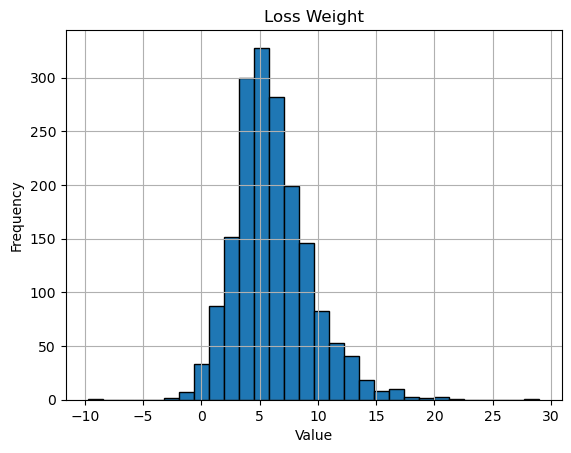

In [719]:
data = dataset[target]
plt.hist(data, bins=30, edgecolor='black')  # bins는 막대의 개수, edgecolor는 막대 테두리 색상
plt.title('Loss Weight')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(f'{ML.imagePath}\\After Weight Histogram.png', dpi=300, bbox_inches='tight')

In [720]:
X, y = ML.split_Xy(dataset, target)

Correlations with Target:
target                         1.000000
Weight_1                       0.491576
BMI_1                          0.460436
VFA_1                          0.418879
WHR_1                          0.343283
FatFreeMass_1                  0.341235
BMR_1                          0.341058
SoftLeanMass_1                 0.340134
SMM_1                          0.337407
apedrin1                       0.287855
Height                         0.245233
MaxVital_1                     0.244470
PBF_1                          0.237081
MinVital_1                     0.217345
apedrin2                       0.168768
Pulse_1                        0.138379
YangbangX                      0.138222
HanbangX                       0.098343
Period                         0.093602
Alcohol_거의 마시지 않는다 (월 1-2회)    0.040836
Coffee_없음                      0.026321
Coffee_마시지않음                   0.018426
Alcohol_기타                     0.000045
Alcohol_주 2회 이상               -0.008639
Coffee_기타     

C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50506 (\N{HANGUL SYLLABLE ANH}) missing from current font.
  fig.canvas.draw()
C:\Users\howsr\anaconda3\Lib\site

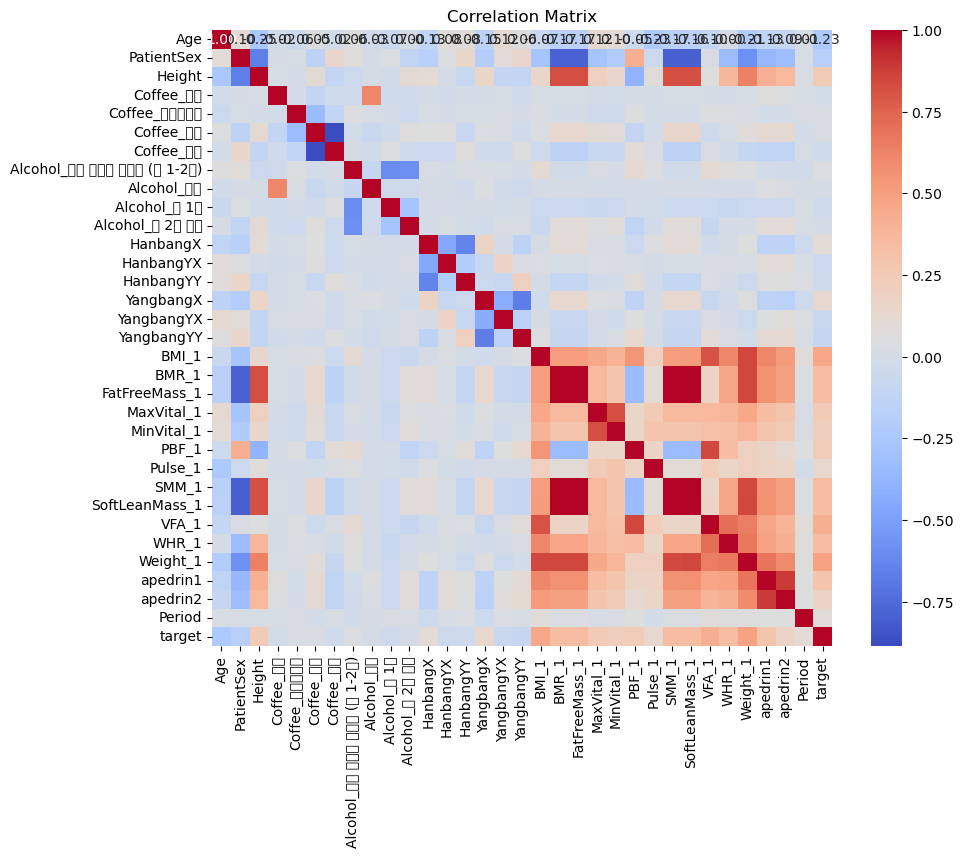

In [721]:
cor_df = ML.calculate_correlations(X,y)

In [722]:
cor_df

target                         1.000000
Weight_1                       0.491576
BMI_1                          0.460436
VFA_1                          0.418879
WHR_1                          0.343283
FatFreeMass_1                  0.341235
BMR_1                          0.341058
SoftLeanMass_1                 0.340134
SMM_1                          0.337407
apedrin1                       0.287855
Height                         0.245233
MaxVital_1                     0.244470
PBF_1                          0.237081
MinVital_1                     0.217345
apedrin2                       0.168768
Pulse_1                        0.138379
YangbangX                      0.138222
HanbangX                       0.098343
Period                         0.093602
Alcohol_거의 마시지 않는다 (월 1-2회)    0.040836
Coffee_없음                      0.026321
Coffee_마시지않음                   0.018426
Alcohol_기타                     0.000045
Alcohol_주 2회 이상               -0.008639
Coffee_기타                     -0.017456


In [723]:
#lasso(self, X, y, alpha =0.1, random_state = 1111) return featurset
featurset = ML.lasso(X, y, 0.1, 11111)

The Number of Selected Features by Lasso: 12
Selected Features by Lasso: Index(['Age', 'Height', 'YangbangX', 'BMR_1', 'MaxVital_1', 'MinVital_1',
       'Pulse_1', 'VFA_1', 'Weight_1', 'apedrin1', 'apedrin2', 'Period'],
      dtype='object')


In [724]:
X = X[featurset]

In [725]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11111)

Best Adjusted R^2 Combination: Features        (Age, YangbangX, MaxVital_1, VFA_1, Weight_1, ...
Adjusted R^2                                              0.28574
AIC                                                   6037.780172
BIC                                                    6083.82772
Name: 3575, dtype: object
Best AIC Combination: Features        (Age, YangbangX, MaxVital_1, VFA_1, Weight_1, ...
Adjusted R^2                                              0.28574
AIC                                                   6037.780172
BIC                                                    6083.82772
Name: 3575, dtype: object
Best BIC Combination: Features        (Age, YangbangX, VFA_1, Weight_1, apedrin1, ap...
Adjusted R^2                                             0.283497
AIC                                                   6042.014635
BIC                                                   6082.945788
Name: 2874, dtype: object


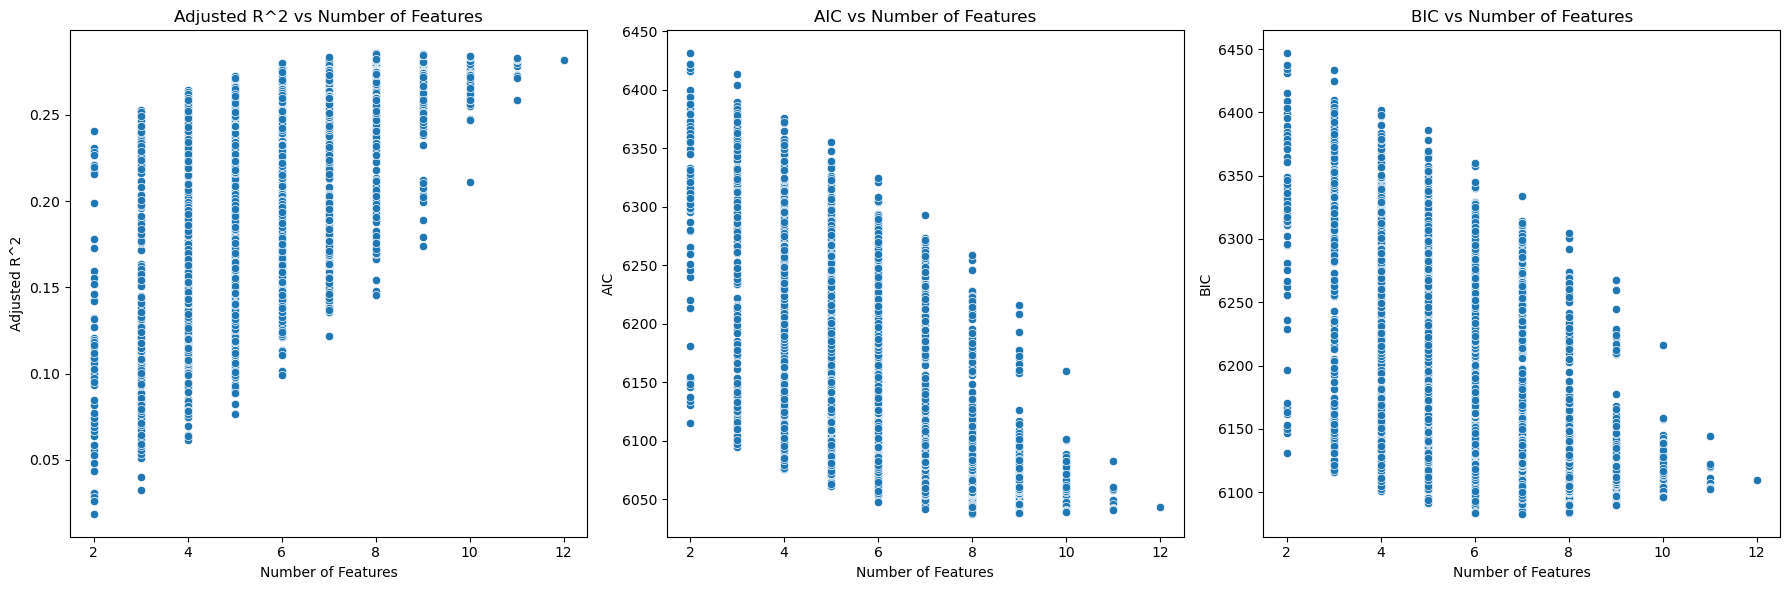

Best R^2 Combination: ('Age', 'YangbangX', 'MaxVital_1', 'VFA_1', 'Weight_1', 'apedrin1', 'apedrin2', 'Period')
Best AIC Combination: ('Age', 'YangbangX', 'MaxVital_1', 'VFA_1', 'Weight_1', 'apedrin1', 'apedrin2', 'Period')
Best BIC Combination: ('Age', 'YangbangX', 'VFA_1', 'Weight_1', 'apedrin1', 'apedrin2', 'Period')


In [726]:
#find_best_feature_set(self, X_train, y_train, image_name = 'XXX', random_state = 1111)
#return adj set, aic set, bic set
set1, set2, set3 = ML.find_best_feature_set(X_train, y_train, image_name = 'Loss Weight')

In [727]:
X_train= X_train[set1]
X_test= X_test[set1]

Model Summary for Loss Weight:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     64.46
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           3.78e-88
Time:                        14:42:09   Log-Likelihood:                -3009.9
No. Observations:                1232   AIC:                             6038.
Df Residuals:                    1223   BIC:                             6084.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2948

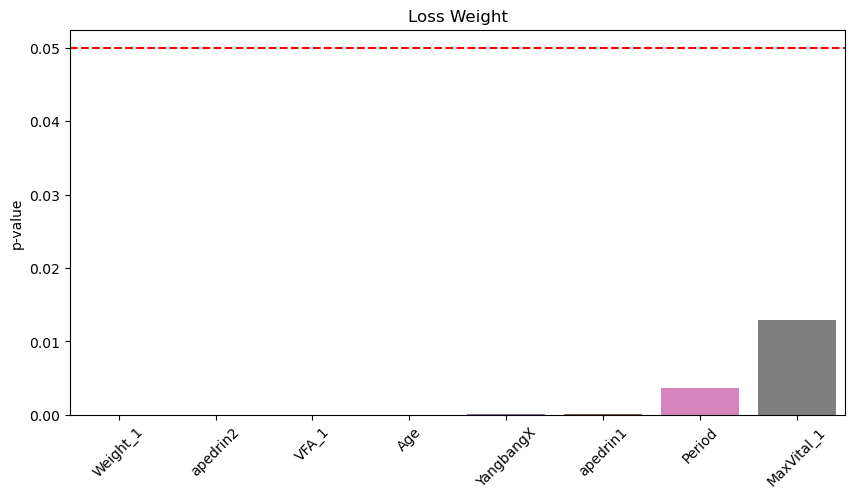

In [728]:
#t_test(self, X_train, y_train, image_name ='XXX')
model = ML.t_test(X_train,y_train, 'Loss Weight')

Model Summary for Loss Weight with absPeriod:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     59.66
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           1.74e-90
Time:                        14:42:10   Log-Likelihood:                -3002.2
No. Observations:                1232   AIC:                             6024.
Df Residuals:                    1222   BIC:                             6076.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

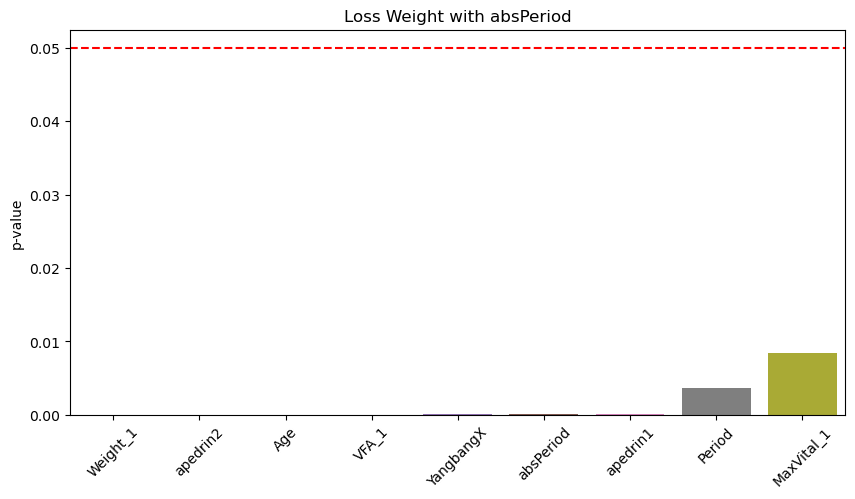

In [729]:
X_train['absPeriod'] = abs(X_train['Period']-X_train['Period'].mean())
X_test['absPeriod'] = abs(X_test['Period']-X_test['Period'].mean())
model = ML.t_test(X_train, y_train, 'Loss Weight with absPeriod')

C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


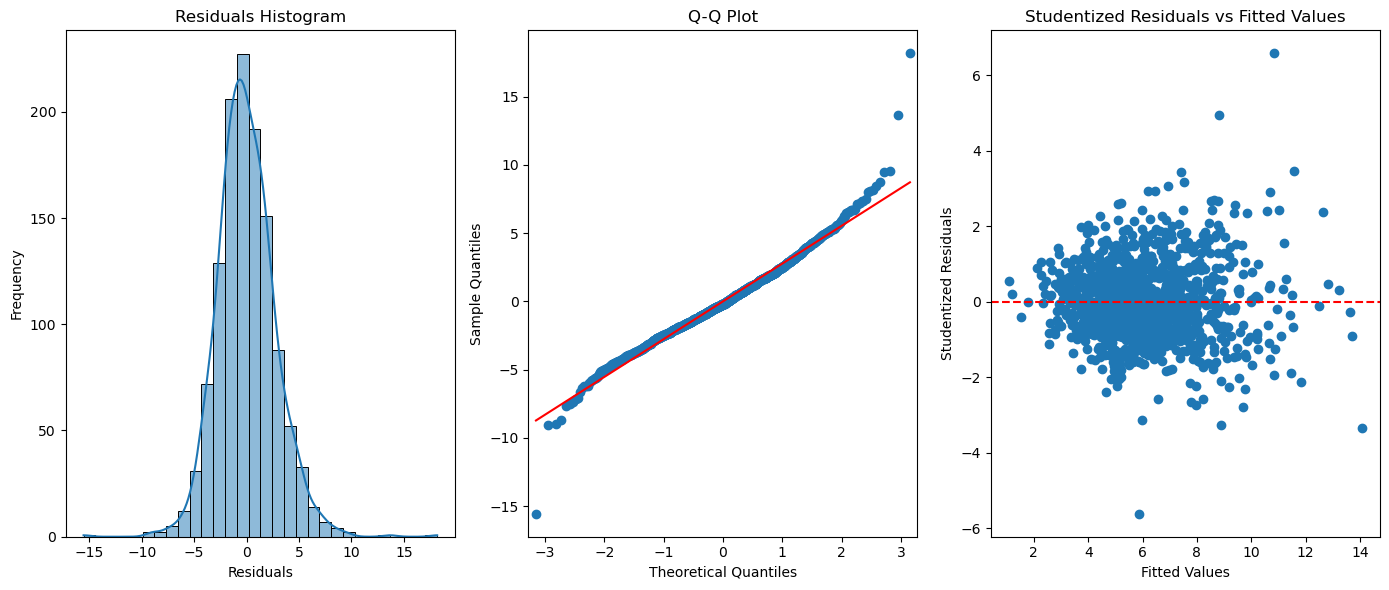

Residuals Summary:
count    1.232000e+03
mean     1.404360e-15
std      2.768604e+00
min     -1.555242e+01
25%     -1.776166e+00
50%     -2.002157e-01
75%      1.639318e+00
max      1.816998e+01
dtype: float64
Durbin-Watson Statistic: 1.9447032395520674
outliers index: [ 138  198  274  276  455  461  472  571  812 1024]


In [730]:
#residual_test(self, model_final, image_name='XXX')
X_, y_ = ML.residual_test(X_train, y_train , 3 ,image_name='Loss Weight')

C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


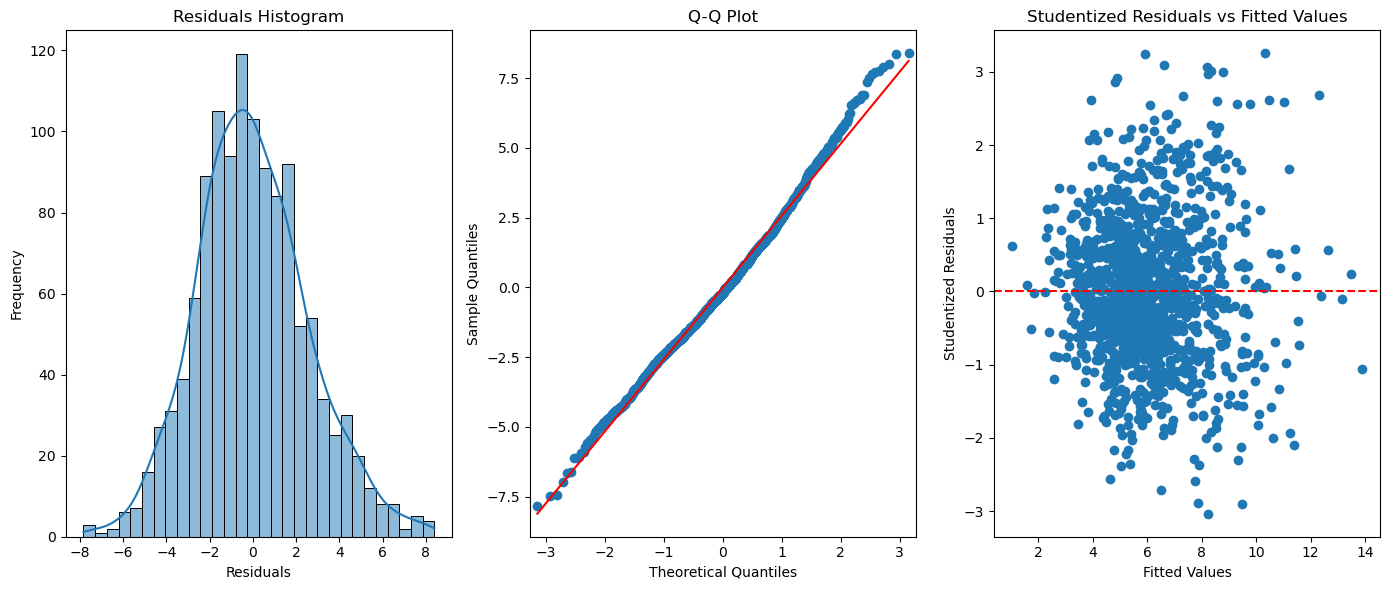

Residuals Summary:
count    1.222000e+03
mean    -5.959953e-16
std      2.578231e+00
min     -7.829308e+00
25%     -1.764343e+00
50%     -2.023572e-01
75%      1.591686e+00
max      8.389985e+00
dtype: float64
Durbin-Watson Statistic: 1.991217545532882
outliers index: [  96  119  439  563  919 1195]


(       Age  YangbangX  VFA_1  Weight_1  apedrin1  apedrin2  Period  absPeriod
 1453  48.0          0  115.2      62.6       115       115    78.0  12.318182
 514   48.0          0   99.0      61.6        95       105    86.0   4.318182
 1317  43.0          0  147.3      70.6       105       105    77.0  13.318182
 352   37.0          1  110.7      71.5       105       105    70.0  20.318182
 359   35.0          0  112.8      69.8       105       105    96.0   5.681818
 ...    ...        ...    ...       ...       ...       ...     ...        ...
 693   39.0          1  156.3      85.6       135       145    97.0   6.681818
 502   29.0          1   86.2      78.6       105       115    94.0   3.681818
 63    19.0          1  198.0      90.3       105       105    61.0  29.318182
 1660  37.0          1  120.3      67.1        95        95    97.0   6.681818
 805   47.0          1  101.7      91.5       125       135    97.0   6.681818
 
 [1216 rows x 8 columns],
 1453     3.6
 514      

In [731]:
ML.residual_test(X_.drop('MaxVital_1',axis =1), y_, image_name='Loss Weight without Outlier')

Model Summary for Percent of Loss Weight without Outlier:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     63.10
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           6.47e-95
Time:                        14:42:17   Log-Likelihood:                -2889.0
No. Observations:                1222   AIC:                             5798.
Df Residuals:                    1212   BIC:                             5849.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

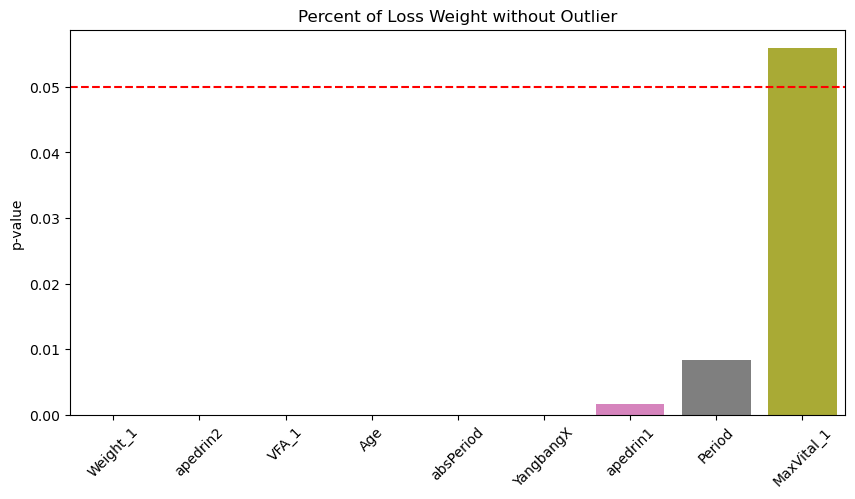

In [732]:
model = ML.t_test(X_, y_, 'Percent of Loss Weight without Outlier')

Model Summary for Percent of Loss Weight without Outlier except MaxVital:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     70.37
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           4.54e-95
Time:                        14:43:43   Log-Likelihood:                -2890.8
No. Observations:                1222   AIC:                             5800.
Df Residuals:                    1213   BIC:                             5846.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

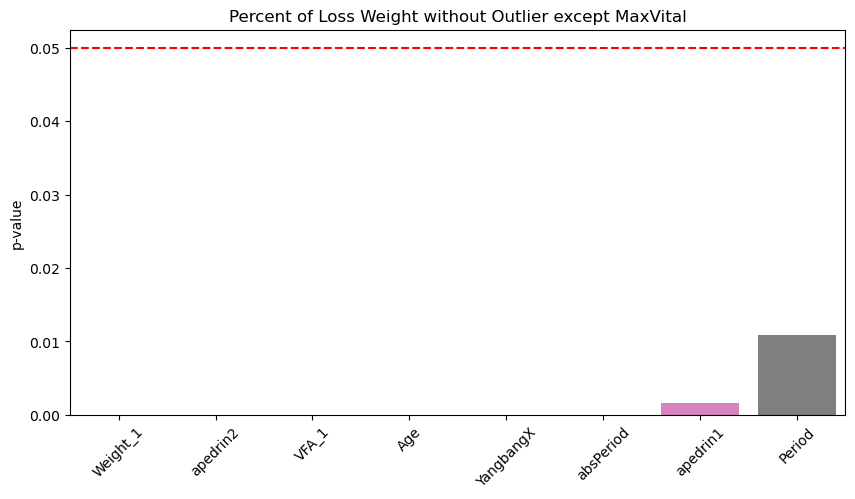

In [737]:
X_ = X_.drop('MaxVital_1',axis =1)
model = ML.t_test(X_, y_, 'Percent of Loss Weight without Outlier except MaxVital')

In [739]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import matplotlib.pyplot as plt

# 1. 독립성 검정 (Durbin-Watson Test)
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat}")

# 2. 등분산성 검정 (Breusch-Pagan Test)
_, bp_pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_pvalue}")

# 3. 정규성 검정 (Shapiro-Wilk Test)
shapiro_stat, shapiro_pvalue = stats.shapiro(model.resid)
print(f"Shapiro-Wilk test statistic: {shapiro_stat}, p-value: {shapiro_pvalue}")


Durbin-Watson statistic: 1.991217545532882
Breusch-Pagan p-value: 1.1012439850216105e-12
Shapiro-Wilk test statistic: 0.9935556054115295, p-value: 3.797906538238749e-05


In [740]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from scipy import stats
from scipy.stats import kstest, anderson
import matplotlib.pyplot as plt
# 1. 등분산성 검정 (White's Test)
white_test_stat, white_pvalue, _, _ = het_white(model.resid, model.model.exog)
print(f"White's test statistic: {white_test_stat}, p-value: {white_pvalue}")

# 2. 정규성 검정 (Kolmogorov-Smirnov Test)
ks_stat, ks_pvalue = kstest(model.resid, 'norm', args=(np.mean(model.resid), np.std(model.resid)))
print(f"Kolmogorov-Smirnov test statistic: {ks_stat}, p-value: {ks_pvalue}")

# 3. 정규성 검정 (Anderson-Darling Test)
ad_result = anderson(model.resid)
print(f"Anderson-Darling test statistic: {ad_result.statistic}")
print("Critical values for various significance levels:")
for i in range(len(ad_result.critical_values)):
    sig_level, crit_value = ad_result.significance_level[i], ad_result.critical_values[i]
    print(f"Significance Level {sig_level}%: Critical Value {crit_value}")

White's test statistic: 123.50239247149912, p-value: 5.941717062001843e-10
Kolmogorov-Smirnov test statistic: 0.03490745156799813, p-value: 0.09939975632083953
Anderson-Darling test statistic: 2.221000673766639
Critical values for various significance levels:
Significance Level 15.0%: Critical Value 0.574
Significance Level 10.0%: Critical Value 0.654
Significance Level 5.0%: Critical Value 0.784
Significance Level 2.5%: Critical Value 0.915
Significance Level 1.0%: Critical Value 1.088


The Number of High leverage points: 66
High leverage points: [   8   12   17   47   69   75  110  118  131  153  199  205  286  299
  314  320  325  338  339  342  389  396  418  431  445  449  467  508
  513  519  551  564  593  642  649  653  672  725  755  756  757  760
  790  792  793  817  864  869  875  885  907  915  938  945  948  954
 1032 1048 1067 1153 1154 1162 1172 1176 1180 1219]
Leverage values of high leverage points: [0.01911404 0.01951289 0.01819927 0.01438508 0.01864814 0.01641074
 0.01623858 0.01463993 0.01394938 0.01887998 0.01645172 0.02122765
 0.01620398 0.01826423 0.02657479 0.01944964 0.01701265 0.01483719
 0.01475495 0.01478846 0.02535032 0.02085848 0.02728561 0.02091751
 0.0193618  0.01990821 0.01372562 0.01444381 0.01588124 0.01506811
 0.01605926 0.01368478 0.01472393 0.01470307 0.01453461 0.01407781
 0.01384829 0.0148762  0.01499499 0.01442263 0.015179   0.01617339
 0.01494981 0.01651847 0.01515091 0.01440502 0.02125732 0.01417984
 0.0169174  0.01633569 0.0

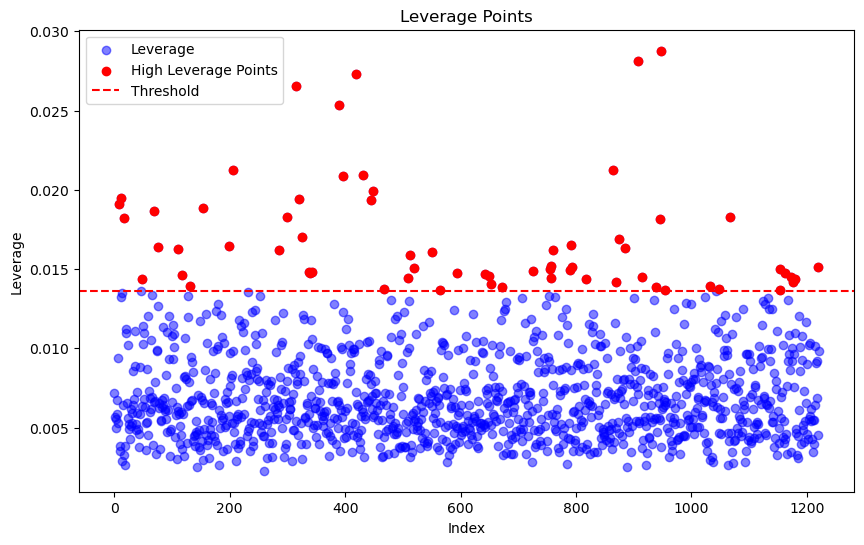

In [742]:
# Hat Matrix (레버리지) 계산
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# high leverage point 기준
high_leverage_threshold = 2 * (X.shape[1] / X.shape[0])

# high leverage points 식별
high_leverage_points = np.where(leverage > high_leverage_threshold)[0]

# 결과 출력
print(f"The Number of High leverage points: {len(high_leverage_points)}")
print(f"High leverage points: {high_leverage_points}")
print(f"Leverage values of high leverage points: {leverage[high_leverage_points]}")

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(leverage)), leverage, alpha=0.5, c='blue', label='Leverage')
plt.scatter(high_leverage_points, leverage[high_leverage_points], c='red', label='High Leverage Points')
plt.axhline(y=high_leverage_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Leverage Points')
plt.xlabel('Index')
plt.ylabel('Leverage')
plt.legend()
plt.show()

In [743]:
X_filtered = X_.drop(index=X_train.index[high_leverage_points])
y_filtered = y_.drop(index=y_train.index[high_leverage_points])
len(X_), len(X_filtered)

(1222, 1156)

Model Summary for Percent of Loss Weight without Outlier except MaxVital:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     66.40
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           1.66e-89
Time:                        14:45:04   Log-Likelihood:                -2739.3
No. Observations:                1156   AIC:                             5497.
Df Residuals:                    1147   BIC:                             5542.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

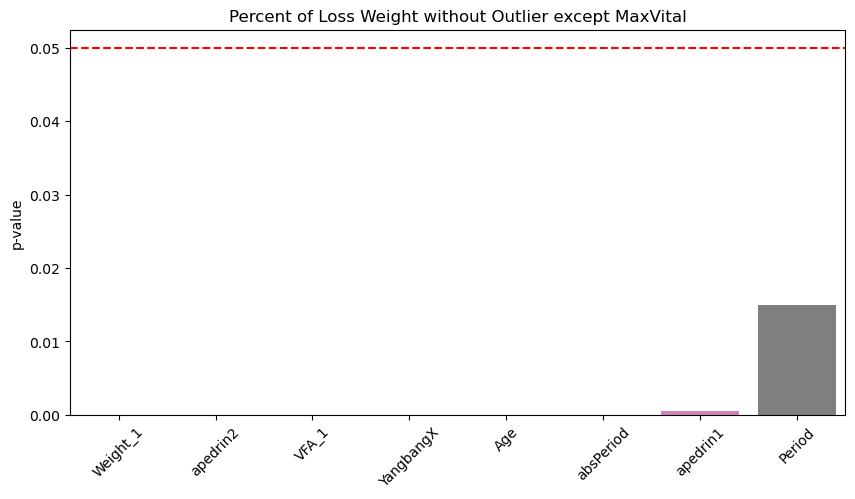

In [744]:
model = ML.t_test(X_filtered, y_filtered, 'Percent of Loss Weight without Outlier except MaxVital')

C:\Users\howsr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


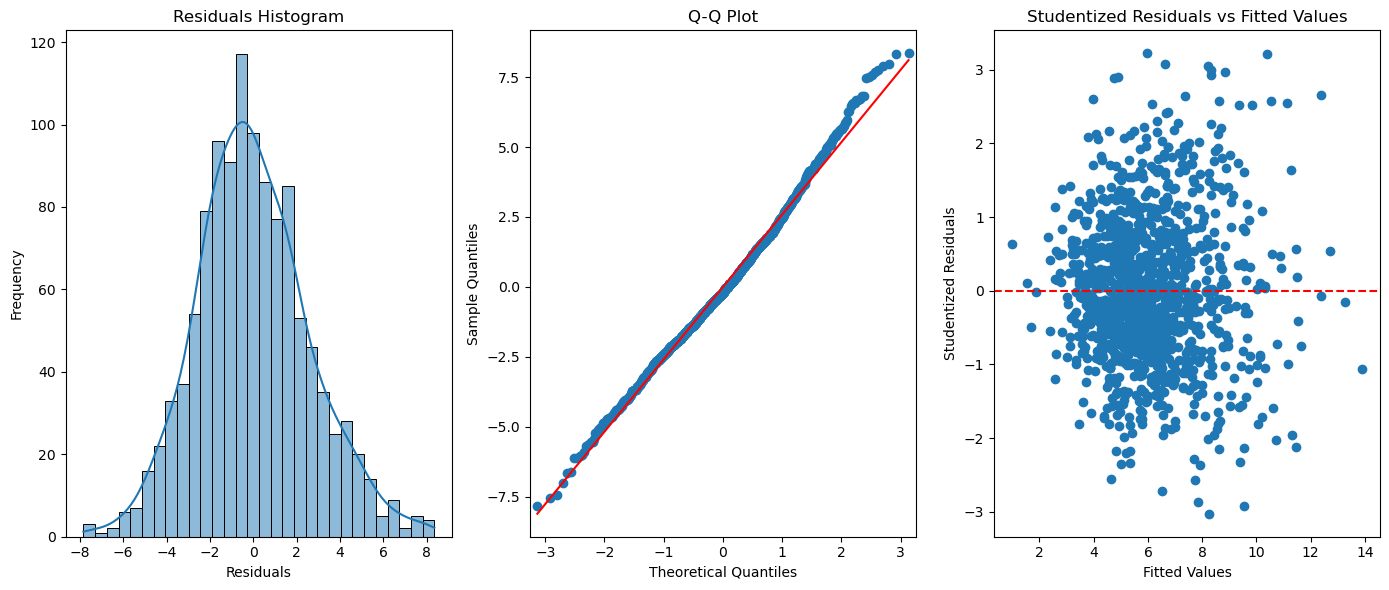

Residuals Summary:
count    1.156000e+03
mean    -3.307619e-15
std      2.588597e+00
min     -7.835427e+00
25%     -1.747642e+00
50%     -2.038571e-01
75%      1.574285e+00
max      8.349867e+00
dtype: float64
Durbin-Watson Statistic: 2.0289396899187673
outliers index: [  90  415  531  867 1130]


(       Age  YangbangX  VFA_1  Weight_1  apedrin1  apedrin2  Period  absPeriod
 1453  48.0          0  115.2      62.6       115       115    78.0  12.318182
 514   48.0          0   99.0      61.6        95       105    86.0   4.318182
 1317  43.0          0  147.3      70.6       105       105    77.0  13.318182
 352   37.0          1  110.7      71.5       105       105    70.0  20.318182
 359   35.0          0  112.8      69.8       105       105    96.0   5.681818
 ...    ...        ...    ...       ...       ...       ...     ...        ...
 693   39.0          1  156.3      85.6       135       145    97.0   6.681818
 502   29.0          1   86.2      78.6       105       115    94.0   3.681818
 63    19.0          1  198.0      90.3       105       105    61.0  29.318182
 1660  37.0          1  120.3      67.1        95        95    97.0   6.681818
 805   47.0          1  101.7      91.5       125       135    97.0   6.681818
 
 [1151 rows x 8 columns],
 1453     3.6
 514      

In [745]:
ML.residual_test(X_filtered, y_filtered, image_name='Loss Weight without high leverage points')

Model Summary for XXX:
                            OLS Regression Results                            
Dep. Variable:           Weight_After   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     70.37
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           4.54e-95
Time:                        15:13:55   Log-Likelihood:                -2890.8
No. Observations:                1222   AIC:                             5800.
Df Residuals:                    1213   BIC:                             5846.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8109      1.

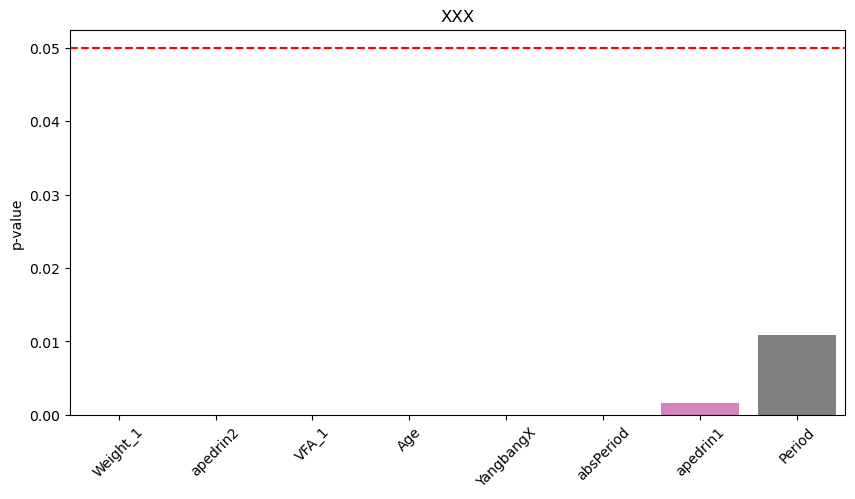

RMSE: 2.6645526140293967


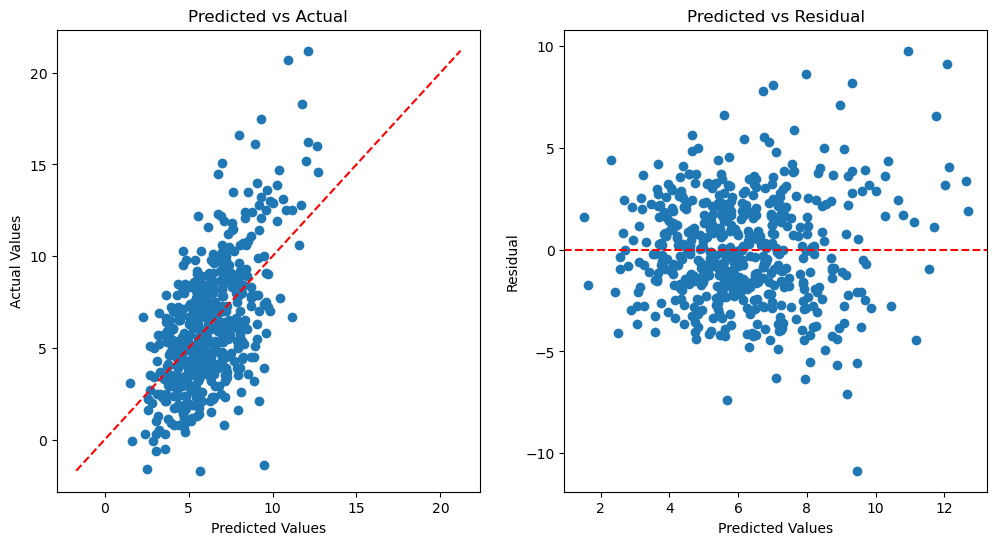

In [753]:
model = ML.t_test(X_, y_)
#X_test = X_test.drop('MaxVital_1', axis = 1)
ML.model_test(model, X_test,y_test)

In [754]:
intercept = model.params[0]  # 상수항 (intercept)
coefficients = model.params[1:]  # 회귀 계수들 (coefficients)

# 특성 이름 (X 데이터프레임이 pandas DataFrame이라면 columns 속성을 사용할 수 있습니다)
feature_names = X_.columns

# 회귀식 문자열 생성
equation = f"y = {intercept:.4f}"
for coef, name in zip(coefficients, feature_names):
    sign = "+" if coef >= 0 else "-"
    equation += f" {sign} {abs(coef):.4f}*{name}"

# 회귀식 출력
print("회귀식:", equation)

회귀식: y = 0.8109 - 0.0321*Age + 0.7430*YangbangX + 0.0140*VFA_1 + 0.0911*Weight_1 + 0.0526*apedrin1 - 0.0808*apedrin2 + 0.0133*Period - 0.0399*absPeriod


C:\Users\howsr\AppData\Local\Temp\ipykernel_28620\1335819864.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]  # 상수항 (intercept)


In [699]:
y = 0.8109 - 0.0321*Age + 0.7430*YangbangX + 0.0140*VFA_1 + 0.0911*Weight_1 + 0.0526*apedrin1 - 0.0808*apedrin2 + 0.0133*Period - 0.0399*absPeriod

(1.3513788, 3.29856, 4.22628)

Text(0.5, 1.0, 'Predicted vs Residual')

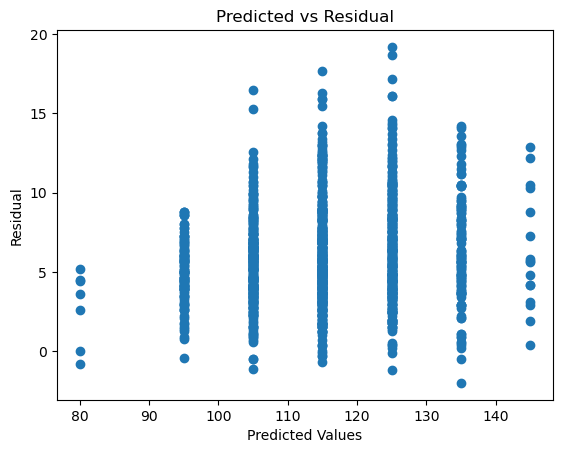

In [755]:
plt.scatter(X_['apedrin2'], y_)

plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Predicted vs Residual')